# Quenched Fermi-Hubbard Model

In [770]:
using Pkg; Pkg.activate()
using KadanoffBaym
using LinearAlgebra, BlockArrays
using UnPack
using JLD

  Activating environment at `~/.julia/environments/v1.6/Project.toml`


In [771]:
using PyPlot
PyPlot.plt.style.use("./paper.mplstyle")

## Model

### Hamiltonian

$$
\begin{align}\begin{split}
    \hat{H} &= - J \sum_{\langle{i,\,j}\rangle}\sum_\sigma \hat{c}^{\dagger}_{i,\sigma} \hat{c}^{\phantom{\dagger}}_{i+1,\sigma} + U\sum_{i=1}^L  \hat{c}^{\dagger}_{i,\uparrow} \hat{c}^{\phantom{\dagger}}_{i,\uparrow}   \hat{c}^{\dagger}_{i,\downarrow} \hat{c}^{\phantom{\dagger}}_{i,\downarrow}, 
\end{split}\end{align}
$$

### Green functions

$$
    G^>_{ij}(t, t') = -i \left\langle \hat{c}^{\phantom{\dagger}}_{i,\uparrow}(t) \hat{c}^{{\dagger}}_{i,\uparrow}(t') \right\rangle\\
    F^>_{ij}(t, t') = -i \left\langle \hat{c}^{\phantom{\dagger}}_{i,\downarrow}(t) \hat{c}^{{\dagger}}_{i,\downarrow}(t') \right\rangle\\
$$

### Self-energies

$$
    \Sigma^{\mathrm{HF}}_{\uparrow,\,ij}(t, t') = {\mathrm{i}}\delta_{ij}\delta(t - t') F^<_{ii}(t, t)\\
    \Sigma^{\mathrm{HF}}_{\downarrow,\,ij}(t, t') = {\mathrm{i}}\delta_{ij}\delta(t - t') G^<_{ii}(t, t)
$$

$$
    \Sigma^{\mathrm{NCA}}_{\uparrow,\,ij}(t, t') = U^2 G_{ij}(t, t') F_{ij}(t, t') F_{ji}(t', t)\\
    \Sigma^{\mathrm{NCA}}_{\downarrow,\,ij}(t, t') = U^2 F_{ij}(t, t') G_{ij}(t, t') G_{ji}(t', t)
$$

## Solving

In [772]:
num_sites = 8;

In [773]:
# 8-site 3D cubic lattice
h = BlockArray{ComplexF64}(undef_blocks, [4, 4], [4, 4])
diag_block = [0 -1 0 -1; -1 0 -1 0; 0 -1 0 -1; -1 0 -1 0]
setblock!(h, diag_block, 1, 1)
setblock!(h, diag_block, 2, 2)
setblock!(h, Diagonal(-1 .* ones(4)), 1, 2)
setblock!(h, Diagonal(-1 .* ones(4)), 2, 1)

full_h = BlockArray{ComplexF64}(undef_blocks, [8, 8], [8, 8])
setblock!(full_h, h |> Array, 1, 1)
setblock!(full_h, h |> Array, 2, 2)
setblock!(full_h, zeros(ComplexF64, 8, 8), 1, 2)
setblock!(full_h, zeros(ComplexF64, 8, 8), 2, 1)

full_h = full_h |> Array;

In [774]:
Base.@kwdef struct FermiHubbardModel
    U::Function
    
#     # two-site 1D chain
#     H = ComplexF64[0 -1 0 0; -1 0 0 0; 0 0 0 -1; 0 0 -1 0] 
    
    # 8-site 3D cubic lattice
    H = full_h
end

FermiHubbardModel

In [775]:
struct FermiHubbardData{T}
    GL::T
    GG::T
    FL::T
    FG::T

    ΣNCA_up_L::T
    ΣNCA_up_G::T
    ΣNCA_down_L::T
    ΣNCA_down_G::T

    # Initialize problem
    function FermiHubbardData(GL::T, GG::T, FL::T, FG::T) where {T}
        new{T}(GL, GG, FL, FG, zero(GL), zero(GG), zero(FL), zero(FG))
    end
end

In [776]:
function fv!(model, data, out, times, t, t′)
    @unpack GL, GG, FL, FG, ΣNCA_up_L, ΣNCA_up_G, ΣNCA_down_L, ΣNCA_down_G = data
    @unpack H, U = model

    # real-time collision integral
    ∫dt(i, j, A, B) =
        sign(j - i) * integrate(times[min(i, j):max(i, j)],[A[t, s] * B[s, t′] for s = min(i, j):max(i, j)])

#     # normal operator ordering
#     ΣHF_up(t, t′) = 1.0im * U * [FL[1, 1, t, t] 0; 0 FL[2, 2, t, t]]
#     ΣHF_down(t, t′) = 1.0im * U * [GL[1, 1, t, t] 0; 0 GL[2, 2, t, t]]
    
    ΣHF_up(t, t′) = 1.0im * U((times[t] + times[t′])/2) * Diagonal([FL[k, k, t, t] for k in 1:num_sites])
    ΣHF_down(t, t′) = 1.0im * U((times[t] + times[t′])/2) * Diagonal([GL[k, k, t, t] for k in 1:num_sites])
    
    out[1] = -1.0im * ((H[1:num_sites, 1:num_sites] + ΣHF_up(t, t′)) * GL[t, t′] + 
            ∫dt(1, t, ΣNCA_up_G, GL) - ∫dt(1, t, ΣNCA_up_L, GL) + ∫dt(1, t′, ΣNCA_up_L, GL) - ∫dt(1, t′, ΣNCA_up_L, GG)
        )

    out[2] = -1.0im * ((H[1:num_sites, 1:num_sites] + ΣHF_up(t, t′)) * GG[t, t′] + 
            ∫dt(1, t, ΣNCA_up_G, GG) - ∫dt(1, t, ΣNCA_up_L, GG) + ∫dt(1, t′, ΣNCA_up_G, GL) - ∫dt(1, t′, ΣNCA_up_G, GG)
        )

    out[3] = -1.0im * ((H[1 + num_sites:2 * num_sites, 1 + num_sites:2 * num_sites] + ΣHF_down(t, t′)) * FL[t, t′] + 
            ∫dt(1, t, ΣNCA_down_G, FL) - ∫dt(1, t, ΣNCA_down_L, FL) + ∫dt(1, t′, ΣNCA_down_L, FL) - ∫dt(1, t′, ΣNCA_down_L, FG)
        )

    out[4] = -1.0im * ((H[1 + num_sites:2 * num_sites, 1 + num_sites:2 * num_sites] + ΣHF_down(t, t′)) * FG[t, t′] +
            ∫dt(1, t, ΣNCA_down_G, FG) - ∫dt(1, t, ΣNCA_down_L, FG) + ∫dt(1, t′, ΣNCA_down_G, FL) - ∫dt(1, t′, ΣNCA_down_G, FG)
        )

    return out
end

function fd!(model, data, out, times, t, t′)
    fv!(model, data, out, times, t, t)
    out .-= adjoint.(out)
end

function self_energies!(model, data, times, t, t′)
    @unpack GL, GG, FL, FG, ΣNCA_up_L, ΣNCA_up_G, ΣNCA_down_L, ΣNCA_down_G = data
    @unpack U = model

    if (n = size(GL, 3)) > size(ΣNCA_up_L, 3)
        resize!(ΣNCA_up_L, n)
        resize!(ΣNCA_up_G, n)
        resize!(ΣNCA_down_L, n)
        resize!(ΣNCA_down_G, n)
    end

    ΣNCA_up_L[t, t′] = U((times[t] + times[t′])/2)^2 .* GL[t, t′] .* FL[t, t′] .* transpose(FG[t′, t])
    ΣNCA_up_G[t, t′] = U((times[t] + times[t′])/2)^2 .* GG[t, t′] .* FG[t, t′] .* transpose(FL[t′, t])

    ΣNCA_down_L[t, t′] = U((times[t] + times[t′])/2)^2 .* FL[t, t′] .* GL[t, t′] .* transpose(GG[t′, t])
    ΣNCA_down_G[t, t′] = U((times[t] + times[t′])/2)^2 .* FG[t, t′] .* GG[t, t′] .* transpose(GL[t′, t])
end

self_energies! (generic function with 1 method)

In [777]:
# quantum numbers
dim = 8

# Allocate the initial Green functions (time arguments at the end)
GL = GreenFunction(zeros(ComplexF64, dim, dim, 1, 1), SkewHermitian)
GG = GreenFunction(zeros(ComplexF64, dim, dim, 1, 1), SkewHermitian)
FL = GreenFunction(zeros(ComplexF64, dim, dim, 1, 1), SkewHermitian)
FG = GreenFunction(zeros(ComplexF64, dim, dim, 1, 1), SkewHermitian)

# Initial condition
N_up = zeros(8)
N_down = zeros(8)
N_up[1:4] = [0.7, 0.0, 0.7, 0.0]
N_down[1:4] = [0.0, 0.25, 0.0, 0.25]

N_up[5:8] = [0.0, 0.4, 0.0, 0.4]
N_down[5:8] = [0.65, 0.0, 0.65, 0.0]

GL[1, 1] = 1.0im * diagm(N_up)
GG[1, 1] = -1.0im * (I - diagm(N_up))
FL[1, 1] = 1.0im * diagm(N_down)
FG[1, 1] = -1.0im * (I - diagm(N_down))

data = FermiHubbardData(GL, GG, FL, FG)
U₀ = 10.
tmax = 5;
model = FermiHubbardModel(U = t -> U₀ * (1 + exp(-10(t - 1.)))^(-1))
# model = FermiHubbardModel(U = t -> 0.5U₀ * (1 + sign(t-1)));
model = FermiHubbardModel(U = t -> -U₀ * [(-1)^k * (1 + exp(-20(t - k)))^(-1) for k in 1:tmax-1] |> sum);
# model = FermiHubbardModel(U = t -> -0.5U₀ * [(-1)^k * (1 + sign(t-k)) for k in 1:tmax-1] |> sum);
# model = FermiHubbardModel(U = t -> 0.);

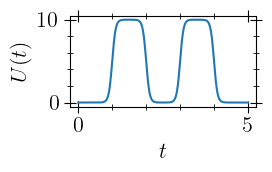

In [778]:
t_vals = 0:0.01:tmax
figure(figsize=(3, 2))
plot(t_vals, model.U.(t_vals))
xlabel("\$t\$")
ylabel("\$U(t)\$")
tight_layout()

In [779]:
round(sum(N_up .+ N_down), digits=3) |> println
round(sum(N_up .- N_down), digits=3) |> print

4.0
0.4

In [780]:
function integrate(x::AbstractVector, y::AbstractVector)
    if isone(length(x))
        return zero(first(y))
    end

    @inbounds retval = (x[2] - x[1]) * (y[1] + y[2])
    @inbounds @fastmath @simd for i = 2:(length(y)-1)
        retval += (x[i+1] - x[i]) * (y[i] + y[i+1])
    end
    return 1 // 2 * retval
end;

In [781]:
atol = 1e-8
rtol = 1e-6;

atol = 1e-5
rtol = 1e-7;

# atol = 1e-6
# rtol = 1e-4;

In [782]:
@time sol = kbsolve!(
    (x...) -> fv!(model, data, x...),
    (x...) -> begin
        println(" t: $(x[2][x[3]])")
        fd!(model, data, x...)
    end,
    [data.GL, data.GG, data.FL, data.FG],
    (0.0, tmax);
    callback = (x...) -> self_energies!(model, data, x...),
    atol = atol,
    rtol = rtol,
);

 t: 0.0
 t: 0.006784927581835264
 t: 0.003427989421452567
 t: 0.003427989421452567
 t: 0.006737676168098025
 t: 0.006737676168098025
 t: 0.011866823796643779
 t: 0.011866823796643779
 t: 0.018772438544162356
 t: 0.018772438544162356
 t: 0.05330051228175524
 t: 0.05330051228175524
 t: 0.08437577864558883
 t: 0.08437577864558883
 t: 0.11234351837303906
 t: 0.11234351837303906
 t: 0.16833697570508466
 t: 0.16833697570508466
 t: 0.2567253262747944
 t: 0.2567253262747944
 t: 0.3702978051543084
 t: 0.3702978051543084
 t: 0.472513036145871
 t: 0.472513036145871
 t: 0.5645067440382773
 t: 0.5645067440382773
 t: 0.6537556806891858
 t: 0.6537556806891858
 t: 0.7390623776578741
 t: 0.7390623776578741
 t: 0.8218459805608542
 t: 0.8218459805608542
 t: 0.9065311133460322
 t: 0.9065311133460322
 t: 0.9901483909642214
 t: 0.9669337731722171
 t: 0.9594208382812776
 t: 0.9594208382812776
 t: 1.0070215907229985
 t: 1.0070215907229985
 t: 1.0498622679205474
 t: 1.0498622679205474
 t: 1.0885797822912613
 t

In [783]:
save("quenched_FH_3D_sol_U_"*string(model.U)*"_tmax_"*string(tmax)*"_atol_"*string(atol)*"_rtol_"*string(rtol)*".jld", "solution", sol)

## Example plots

### Load data

In [784]:
# loaded_sol = load("FH_1D_sol_U_0.5_atol_1e-8_rtol_1e-6.jld")
loaded_sol = load("quenched_FH_3D_sol_U_"*string(model.U)*"_tmax_"*string(tmax)*"_atol_"*string(atol)*"_rtol_"*string(rtol)*".jld")

Dict{String, Any} with 1 entry:
  "solution" => KBState{Vector{GreenFunction{ComplexF64, 4, Array{ComplexF64, 4…

In [785]:
num_points = (loaded_sol["solution"].t |> size)[1]

100

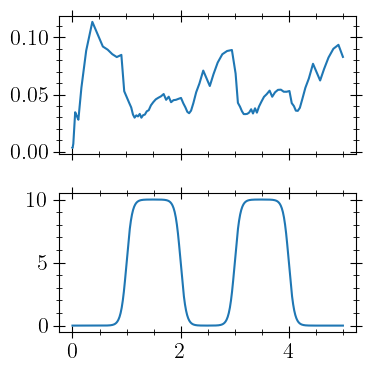

In [786]:
tt = loaded_sol["solution"].t
figure(figsize=(4, 4))
ax = subplot(211)
ax.plot(tt[2:end], map(t -> t[2] - t[1], zip(tt[1:end-1], tt[2:end])), "-")
ax.set_xticklabels([])
ax = subplot(212)
ax.plot(t_vals, model.U.(t_vals))
tight_layout()

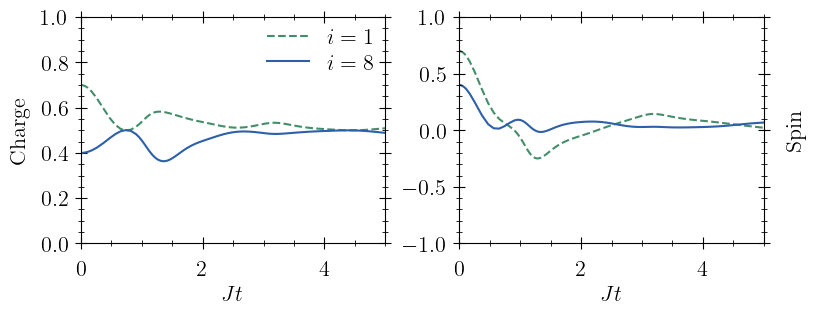

In [787]:
xpad = 8
ypad = 5

figure(figsize = (8, 3))

ax = subplot(121)
idx_1 = 1
idx_2 = 8

plot(loaded_sol["solution"].t, [imag(loaded_sol["solution"].u[1][idx_1, idx_1, k, k] .+ loaded_sol["solution"].u[3][idx_1, idx_1, k, k]) for k = 1:num_points], 
    label = "\$ i=1\$", lw=1.5, ls = "--", c = "#438E6A")

plot(loaded_sol["solution"].t, [imag(loaded_sol["solution"].u[1][idx_2, idx_2, k, k] .+ loaded_sol["solution"].u[3][idx_2, idx_2, k, k]) for k = 1:num_points], 
    label = "\$ i=8\$", lw=1.5, ls = "-", c = "#2D5FAA")

xlim(0, tmax)
# ax.set_xticks([0, 8, 16, 24, 32])
ylim(-0, 1)
xlabel("\$J t\$")
ylabel("Charge", labelpad = 8)
ax.xaxis.set_tick_params(pad = xpad)
ax.yaxis.set_tick_params(pad = ypad)
ax.legend(loc = "best", handlelength = 1.9, frameon = false, borderpad = 0, labelspacing = 0.25)

ax = subplot(122)

plot(loaded_sol["solution"].t, [imag(loaded_sol["solution"].u[1][idx_1, idx_1, k, k] .- loaded_sol["solution"].u[3][idx_1, idx_1, k, k]) for k = 1:num_points], 
    label = "\$ i=2\$", lw=1.5, ls = "--", c = "#438E6A")

plot(loaded_sol["solution"].t, [imag(loaded_sol["solution"].u[1][idx_2, idx_2, k, k] .- loaded_sol["solution"].u[3][idx_2, idx_2, k, k]) for k = 1:num_points], 
    label = "\$ i=2\$",  lw=1.5, ls = "-", c = "#2D5FAA")

xlim(0, tmax)
ylim(-1, 1)
# ax.set_xticks([0, 8, 16, 24, 32])
xlabel("\$J t\$")
ylabel("Spin", labelpad = 16)
ax.xaxis.set_tick_params(pad = xpad)
ax.yaxis.set_tick_params(pad = ypad)
ax.set_axisbelow(false)
ax.yaxis.set_label_position("right")

tight_layout(pad = 0.1, w_pad = 0.5, h_pad = 0)
# savefig("fermi_hubbard_T.pdf")

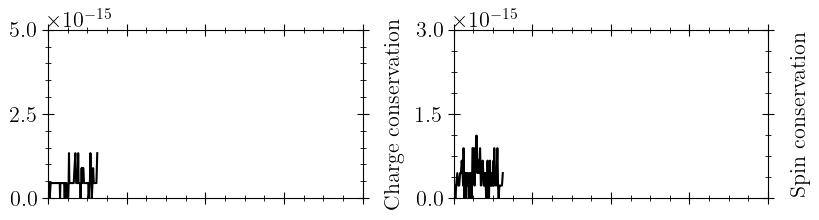

In [788]:
Gs = loaded_sol["solution"]

xpad = 8
ypad = 5

figure(figsize = (8, 2))

ax = subplot(121)
plot(loaded_sol["solution"].t, [(sum(Gs.u[1][i, i, k, k] for i = 1:num_sites) |> imag) .+ (sum(Gs.u[3][i, i, k, k] for i = 1:num_sites) |> imag) for k = 1:num_points] 
    .- sum(N_up .+ N_down)  .|> abs, 
    label = "\$ c \$", ls = "-", c = "k")
xlim(0, tmax)
ax.set_xticks([0, 8, 16, 24, 32])
ax.set_xticklabels([])
yticks([k for k in 0:0.5:1] .* 5e-15)
ylim([0.0, 1] .* 5e-15)
ylabel("Charge conservation", labelpad = 16)
ax.yaxis.set_label_position("right")

ax = subplot(122)
plot(loaded_sol["solution"].t, [(sum(Gs.u[1][i, i, k, k] for i = 1:num_sites) |> imag) .- (sum(Gs.u[3][i, i, k, k] for i = 1:num_sites) |> imag) for k = 1:num_points] 
    .- sum(N_up .- N_down) .|> abs, 
    label = "\$ c \$", ls = "-", c = "k")
xlim(0, tmax)
ax.set_xticks([0, 8, 16, 24, 32])
yticks([k for k in 0:0.5:1] .* 3e-15)
ax.set_xticklabels([])
ylim([0.0, 1] .* 3e-15)
ylabel("Spin conservation", labelpad = 16)
ax.yaxis.set_label_position("right")

tight_layout(pad = 0.0, w_pad = 0.5, h_pad = 0)
# savefig("fermi_hubbard_example_T_inset.pdf")

In [789]:
using FFTW, Interpolations

In [790]:
# quantum number to look at
idx = 1

ρτ, (τs, ts) = wigner_transform_itp((loaded_sol["solution"].u[2][idx, idx, :, :] - loaded_sol["solution"].u[1][idx, idx, :, :]), 
    loaded_sol["solution"].t[1:end], fourier=false);
ρω, (ωs, ts) = wigner_transform_itp((loaded_sol["solution"].u[2][idx, idx, :, :] - loaded_sol["solution"].u[1][idx, idx, :, :]), 
    loaded_sol["solution"].t[1:end], fourier=true);

In [791]:
t_scale = 1
ω_scale = 1;

In [792]:
function meshgrid(xin,yin)
  nx=length(xin)
  ny=length(yin)
  xout=zeros(ny,nx)
  yout=zeros(ny,nx)
  for jx=1:nx
      for ix=1:ny
          xout[ix,jx]=xin[jx]
          yout[ix,jx]=yin[ix]
      end
  end
  return (x=xout, y=yout)
end

Y, X = meshgrid(loaded_sol["solution"].t, loaded_sol["solution"].t);

In [793]:
cmap = "gist_heat";

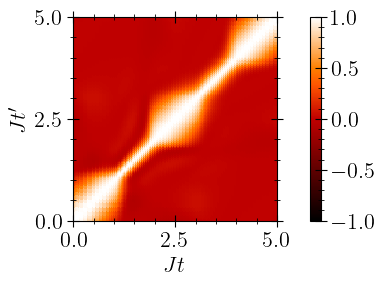

In [794]:
figure(figsize=(7, 3))
t_scale = 1
vmin = -1.0
vmax = 1.0

# center = floor(length(ts) / 2) |> Int 

# ax = subplot(121)
# plot(t_scale * τs, -ρτ[:, center] |> imag, ls="-", c="C0", lw=1.5)
# ax.set_xlabel("\$J \\tau\$")
# ax.set_xlim(-t_scale * tmax / 2, t_scale * tmax / 2)
# ax.set_ylim(-1, 1)
# ax.set_xticks(t_scale .* [-tmax/2, -tmax/4, 0, tmax/4, tmax/2])
# ax.xaxis.set_tick_params(pad=xpad)
# ax.yaxis.set_tick_params(pad=ypad)
# ax.set_ylabel("\$  A_{11, \\uparrow}(T_{\\mathrm{max}}/2, \\tau)_W \$")

ax = subplot(111)
heatmap = ax.pcolormesh(X, Y, imag(loaded_sol["solution"].u[1][1, 1, :, :]) .- imag(loaded_sol["solution"].u[2][1, 1, :, :]), cmap=cmap, rasterized=true, vmin=vmin, vmax=vmax)
heatmap.set_edgecolor("face")
ax.set_aspect("equal")
cbar = colorbar(mappable=heatmap)
cbar.formatter.set_powerlimits((0, 0))
ax.set_xlabel("\$J t\$")
ax.set_ylabel("\$J t'\$")
ax.set_xlim(0, t_scale * tmax)
ax.set_ylim(0, t_scale * tmax)
ax.set_xticks(t_scale .* [0, tmax/2, tmax])
ax.set_yticks(t_scale .* [0, tmax/2, tmax])

tight_layout(pad=0.75, w_pad=0.5, h_pad=0)

# savefig("fermi_hubbard_example_two_times.pdf")